# Diagnostic video

In [14]:
import warnings
warnings.simplefilter('ignore')

It is sometimes useful to fully visualize the reduction process of raw images 🧐

In this case study we will see how to produce that with prose. One thing we want to monitor in the following observation is how well images are aligned and the quality of the PSF

## Retrieving the images

As usual, we parse our images folder with a [FitsManager](prose.FitsManager) instance

In [15]:
from prose import FitsManager

fm = FitsManager("/Users/lgrcia/data/RAW_Callisto_20210927_Sp2315-0627_I+z/")
fm

Parsing FITS:   0%|          | 0/255 [00:00<?, ?it/s]

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
4,2021-09-26,Callisto,,bias,,2048,2088,2
2,2021-09-26,Callisto,,dark,,2048,2088,8
15,2021-09-26,Callisto,I+z,flat,,2048,2088,13
1,2021-09-26,Callisto,I+z,light,Sp2315-0627,2048,2088,232


## Reference sequence

Since the goal is to align raw images, let's detect reference stars on a reference image.

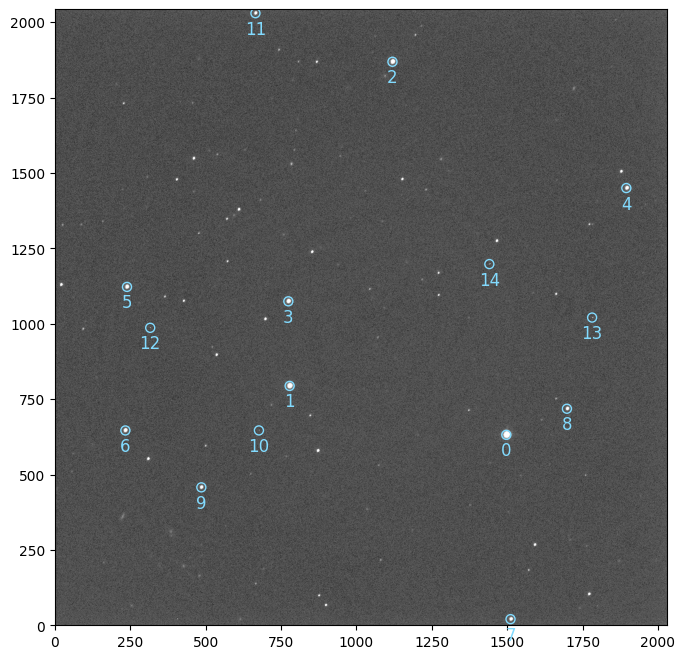

In [16]:
from prose import FITSImage, Sequence, blocks

# We take one of the image as a reference one
reference = FITSImage(fm.all_images[50])

# Defining the reference sequence
reference_sequence = Sequence([
    blocks.Calibration(fm.all_darks, fm.all_flats, fm.all_bias), # calibration
    blocks.Trim(),                                   # triming
    blocks.PointSourceDetection(n=15),               # stars detection
])

# Running it and displaying the reference stars
reference_sequence.run(reference, show_progress=False)
reference.show()

We can now reuse this sequence and apply it to the complete set of images.

## The rest of the sequence

Let's now build the sequence to take the measurements and align images

In [17]:
# Just running it on a test image
test_image = FITSImage(fm.all_images[10])

main_sequence = Sequence([
    *reference_sequence,
    blocks.AlignReferenceSources(reference),
    blocks.Cutouts(41),
    blocks.MedianEPSF(),
    blocks.psf.Moffat2D()
])

main_sequence.run(test_image)

  0%|          | 0/1 [00:00<?, ?images/s]

WARNING AlignReferenceSources discarded image 0


## The [PlotVideo](prose.blocks.vizualisation.PlotVideo) block

In [18]:
blocks.Cutouts(41)(test_image)

WARNING Cutouts discarded Image


Image(data=array([[815.68269496, 816.21211213, 807.57991286, ..., 790.02584008,
        867.42228859, 868.12904544],
       [735.0866766 , 739.00819704, 815.65034024, ..., 819.8703555 ,
        814.13829968, 811.14077785],
       [820.59856504, 769.97736743, 748.94836222, ..., 786.26474991,
        789.17001804, 844.68782027],
       ...,
       [755.90319289, 752.10965182, 741.38192123, ..., 789.82334309,
        875.58967353, 747.02792752],
       [807.93662769, 796.00272201, 796.99015686, ..., 804.63887236,
        794.21533582, 763.66820752],
       [748.5754884 , 806.34389973, 772.54215863, ..., 747.01665007,
        777.03379896, 794.69366064]]), metadata={'telescope': 'Callisto', 'exposure': 12.0, 'ra': '23 15 54.51', 'dec': '-06 27 46.4', 'filter': 'I+z', 'date': '2021-09-26T23:30:40.650', 'jd': 2459484.479637153, 'object': 'Sp2315-0627', 'pixel_scale': 0.33, 'overscan': (22, 8), 'path': '/Users/lgrcia/data/RAW_Callisto_20210927_Sp2315-0627_I+z/Sp2315-0627-S001-R001-C037-I+z.ft

To build a video of the reduction process of all images, we will use the [PlotVideo](prose.blocks.vizualisation.PlotVideo) block which takes as input a plotting function applied to an image. Let's write it

AttributeError: epsf cannot be interpreted as Image attribute

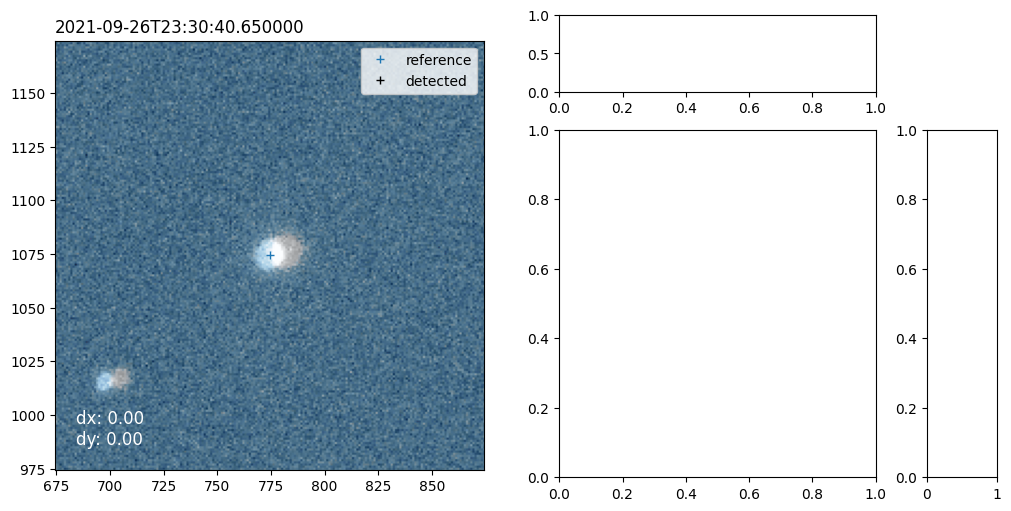

In [19]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from prose import viz

# focusing plot on 
xy = reference.sources.coords[3]

def plot(image):
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    
    # Alignment
    subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1.])
    ax = subfigs[0].subplots(1, 1)
    reference.show(ax=ax, cmap="Greys_r", sources=False)
    ax.plot(*reference.sources.coords.T, "+", c="C0", label="reference")
    image.show(cmap="Blues_r", alpha=0.5, ax=ax, sources=False)
    ax.plot(*image.sources.coords.T, "+", c="k", label="detected")
    ax.set_xlim(*(xy[0] + np.array([-1, 1])*100))
    ax.set_ylim(*(xy[1] + np.array([-1, 1])*100))
    viz.corner_text(f"dx: {image.transform.translation[0]:.2f}\ndy: {image.transform.translation[1]:.2f}", c="w")
    ax.set_title(image.date.isoformat(), loc="left")
    plt.legend()
    
    # PSF
    axes = subfigs[1].subplots(2, 2, gridspec_kw=dict(
        width_ratios=[9, 2], 
        height_ratios=[2, 9],
        wspace=0,
        hspace=0))

    ax = axes[1, 0]
    axr = axes[1, 1]
    axt = axes[0, 0]
    axes[0, 1].axis("off")
    ax.imshow(image.epsf.data, alpha=1, cmap="Blues_r", origin="lower")
    x, y = np.indices(image.epsf.shape)

    axt.plot(y[0], np.mean(image.epsf.data, axis=0), c="C0", label="data")
    #axt.plot(y[0], np.mean(image.epsf_model, axis=0), "--", c="k", label="model")
    axt.axis("off")
    #axt.set_title(f"Median PSF Model ({image.psf_model_block})", loc="left")
    axt.legend()

    axr.plot(np.mean(image.epsf.data, axis=1), y[0], c="C0")
    #axr.plot(np.mean(image.psf_model, axis=1), y[0], "--", c="k")
    axr.axis("off")
    ax.text(1, 1, f"$\sigma_x$: {image.epsf.params['sigma_x']:.2f} pix\n"
                f"$\sigma_y$: {image.epsf.params['sigma_y']:.2f} pix\n"
                f"$\\theta$: {image.epsf.params['theta']/np.pi*180:.2f}°", c="w")
        
    plt.tight_layout()
    

# Here is the result
plot(test_image)

And use it within the full sequence

In [ ]:
process = Sequence([
    *main_sequence,
    blocks.vizualisation.PlotVideo(plot, "../_static/diagnostic_video.mp4")
])

# only 10 images for example
process.run(fm.all_images[0:10])

  0%|          | 0/10 [00:00<?, ?images/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## A concise code

We have seen all the steps and details on how to use a plotting function within a sequence. For reference and clarity here is the final code containing the reference and main sequences:

In [ ]:
from prose import FITSImage, Sequence, blocks

# We take one of the image as a reference one
reference = FITSImage(fm.all_images[50])

# Defining the reference sequence
reference_sequence = Sequence([
    blocks.Calibration(                 # calibration
        fm.all_darks, 
        fm.all_flats, 
        fm.all_bias
    ), 
    blocks.Trim(),                       # triming
    blocks.PointSourceDetection(n=15),   # stars detection
])

# Running it and displaying the reference stars
reference_sequence.run(reference, show_progress=False)

# Main Sequence
# -------------
main_sequence = Sequence([
    *reference_sequence,
    blocks.AlignReferenceSources(reference),    # computing shift
    blocks.Cutouts(41),                         # extracting stars cutouts
    blocks.MedianEPSF(),                        # combining into a median PSF
    blocks.psf.Moffat2D(),                      # PSF model
    blocks.vizualisation.PlotVideo(             # Video
        plot, "../_static/diagnostic_video.mp4"
        )
])

main_sequence.run(fm.all_images[40:50]) # just 10 for example

  0%|          | 0/10 [00:00<?, ?images/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<video height="350px" loop autoplay muted style=" display: block; margin-left: auto; margin-right: auto;">
  <source src="../_static/diagnostic_video.mp4" type="video/mp4">
</video>

![](static/diagnostic_video.gif)